In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from scipy.stats import randint as sp_randint
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from scipy.stats import expon
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

np.random.seed(0)

In [2]:
dfs = {}
for file in ['../data/MovAve15_Data.csv', '../data/MovAve30_Data.csv',
             '../data/MovAve60_Data.csv', '../data/MovAve90_Data.csv']:
    dfs[file[14:16]] = pd.read_csv(file)

In [3]:
#for df in dfs.values():
#    df.drop(['elo_home', 'elo_away'], axis=1, inplace=True)

In [4]:
class KFold_Scaled:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, df, y, groups=None):
        from sklearn.model_selection import StratifiedKFold
        from sklearn.preprocessing import LabelEncoder
        import numpy as np

        sk = StratifiedKFold(random_state=0, n_splits=self.n_splits, shuffle=True)

        train_all = df[df['year'] < 1]

        for train_idx, valid_idx in sk.split(np.zeros(train_all.shape[0]),
                                             LabelEncoder().fit_transform(df['year'])):
            yield (train_idx, valid_idx)

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [5]:
class CustomKFold:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, df, y, groups=None):
        from sklearn.model_selection import StratifiedKFold
        import numpy as np

        sk = StratifiedKFold(random_state=0, n_splits=self.n_splits, shuffle=True)

        train_all = df[df['year'] < 2019]

        for train_idx, valid_idx in sk.split(np.zeros(train_all.shape[0]), train_all['year']):
            yield (train_idx, valid_idx)

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# cross_validate_by_year(your_classifier_with_parameters_set, df) 
        
# after you're done modeling and have the `best_estimator`, uncomment the following lines and run them
# best_predictions = best_estimator.predict_proba(test.drop('Target_Var', axis=1))
# test_actuals = test['Target_Var']

# compare the `test_actuals` with the `best_predictions`

# with open('best_estimator_{}'.format(moving_average_setting), 'wb') as f:
#     pickle.dump(best_estimator, f, protocol=-1)

/home/gpt/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.9min finished


best estimator accuracy for 15: 0.5119
[5]


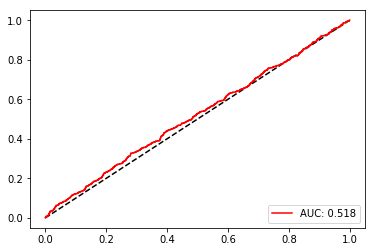

/home/gpt/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.9min finished


best estimator accuracy for 30: 0.5225
[5]


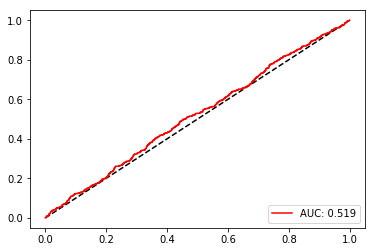

/home/gpt/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.0min finished


best estimator accuracy for 60: 0.5176
[5]


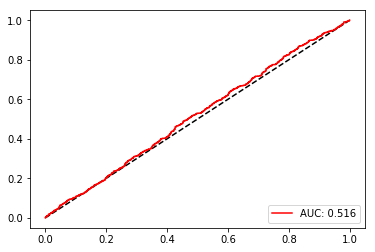

/home/gpt/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.7min finished


best estimator accuracy for 90: 0.4987
[5]


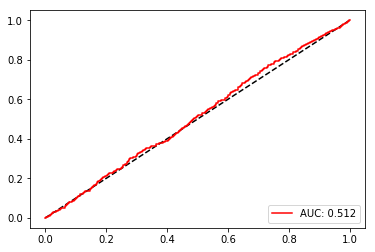

In [6]:
for name, df in dfs.items():
    
    data_scaled = df.copy()
    scalers = {}

    for col in df:
        if df[col].nunique() > 2:
            scalers[col] = MinMaxScaler((-1, 1))
            data_scaled[col] = scalers[col].fit_transform(df[col].values.reshape(-1, 1))

    train = data_scaled[data_scaled['year'] < 1]
    test = data_scaled[data_scaled['year'] == 1]

    x_train = train.drop(['Target_Var'], axis=1)
    y_train = train['Target_Var']

    x_test = test.drop(['Target_Var'], axis=1)
    y_test = test['Target_Var']

    lr = LogisticRegression(random_state=0,
                            solver='liblinear',
                            )

    params_lr = {'C': expon(scale=1),
                 }

    lr_cv = RandomizedSearchCV(lr,
                               params_lr,
                               n_iter=100,
                               cv=KFold_Scaled(),
                               #scoring='roc_auc',
                               random_state=0,
                               n_jobs=-1,
                               verbose=1,
                               )

    lr_cv.fit(x_train, y_train)

    print('best estimator accuracy for {}: {:.4f}'.format(name, lr_cv.best_estimator_.score(x_test, y_test)))
    print(lr_cv.best_estimator_.n_iter_)
    fpr, tpr, thresholds = roc_curve(y_test, lr_cv.best_estimator_.predict_proba(x_test)[:,1])
    best_auc = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, 'r', label='AUC: {:.3f}'.format(best_auc))
    plt.legend(loc='lower right')
    plt.show()

    with open('best_lr_model_acc_{}.pckl'.format(name), 'wb') as f:
        pickle.dump(lr_cv.best_estimator_, f)
    with open('best_lr_model_cv_acc_{}.pckl'.format(name), 'wb') as f:
        pickle.dump(lr_cv, f)

In [36]:
lasso = Lasso(random_state=0)
lasso.fit(x_train, y_train)
[x for x in zip(lasso.coef_, x_train.columns) if x[0] > 0]

[]

In [32]:
lasso.score(x_test, y_test)

-0.0008049428455603191